In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import pandas as pd
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

In [2]:
TABLE_FILE = Path('analytical-fitting-points.csv')
RESULTS_KAPPA_FILE_PREFIX = 'results_kappa'
B_MIN = 0.5
B_MAX = 1.5
N_B_VALUES = 5
B_REM = 1.26
H_FC = 25e-3
N_SEGMENTS = 5
PHI_S = 60
L_ELEMENT_MIN = 1e-3
L_ELEMENT_MAX = 3e-2
N_NARROW = 2
B_LOW = 0
FIELD_FRACTION = 35.0/100

In [3]:
table = pd.read_csv(TABLE_FILE,index_col=0)

In [4]:
nrows, ncolumns = table.shape

In [5]:
FIXED_PARAMETERS = {
        "h_fc": H_FC,
        "R_e": 1,
        "n_II": N_SEGMENTS,
        "n_IV": N_SEGMENTS,
        "phi_C_II": 0,
        "phi_S_II": PHI_S,
        "phi_S_IV": PHI_S,
        "mu_r_II": 1.05,
        "mu_r_IV": 1.05,
        "linear_iron": 1,
        "mu_r_iron": 5e2,
        "l_element_min": L_ELEMENT_MIN,
        "l_element_max": L_ELEMENT_MAX,
        "n_narrow": N_NARROW,
             }

n_II = FIXED_PARAMETERS["n_II"]
n_IV = FIXED_PARAMETERS["n_IV"]

n = n_II + n_IV

# expand parameters to include remanence magnitudes for each segment
FIXED_PARAMETERS = teslamax.expand_parameters_from_remanence_array(B_REM*np.ones(n), 
                                                        FIXED_PARAMETERS, 
                                                        "B_rem")

In [6]:
parameters_list = []
B_est_list = []
for isimulation, row in table.iterrows():
    parameters = FIXED_PARAMETERS.copy()
    parameters["R_i"] = 1e-3*row["R1  (Ri)"]
    parameters["R_o"] = 1e-3*row["R2  (Ro)"]
    parameters["R_g"] = 1e-3*row["R3  (Rg)"]
    parameters["R_s"] = 1e-3*row["R4  (Rs)"]
    
    parameters_list.append(parameters.copy())
    
    B_est_list.append(row["B_estimado"])

In [7]:
B_values = np.linspace(B_MIN,B_MAX,N_B_VALUES)

In [8]:
Kappa_data = np.zeros((nrows,N_B_VALUES))

In [13]:
target_function = teslamax.calculate_ramp_profile
    
for i in range(0,nrows):
    
    results_path = Path(RESULTS_KAPPA_FILE_PREFIX + "_%s.txt" %(i,))
    results_path.write_text("B[T]\tKappa[]\n")
    
    tmpd = TeslaMaxPreDesign(parameters_list[i])
    
    for j, B_high in enumerate(B_values):
        
        target_args = (B_high,B_LOW,FIELD_FRACTION)
        
        try:
            alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
            Kappa = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
            Kappa_data[i,j] = Kappa
            
            results_str = "%.2f\t%.4f\n" %(B_high,Kappa,)
            with results_path.open(mode='a',buffering=1) as f:
                    f.write(results_str)
                    f.flush()
                    os.fsync(f.fileno())
                    
        except:
            pass

## Plotting the results

In [45]:
import nemplot

In [44]:
results_files = sorted(Path('.').glob(RESULTS_KAPPA_FILE_PREFIX + "_[0-9]*"))

In [48]:
np.loadtxt("results_kappa_0.txt",skiprows=1)

array([[0.5   , 0.0497],
       [0.75  , 0.0669],
       [1.    , 0.1191],
       [1.25  , 0.1643],
       [1.5   , 0.2003]])

In [ ]:
np.tra

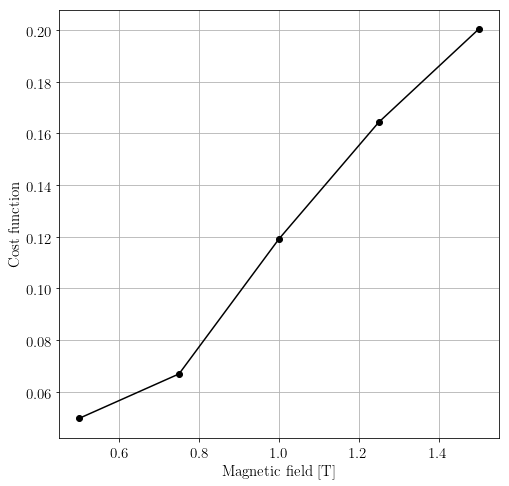

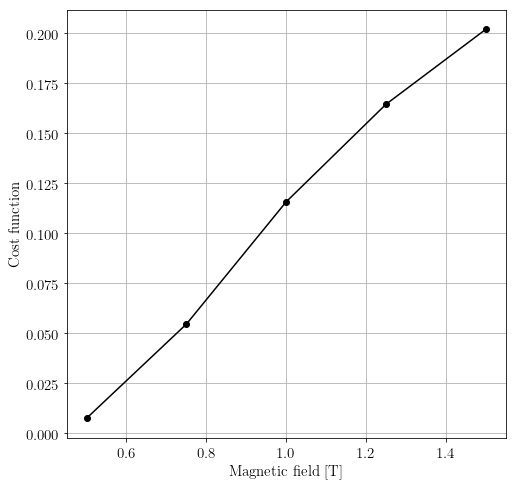

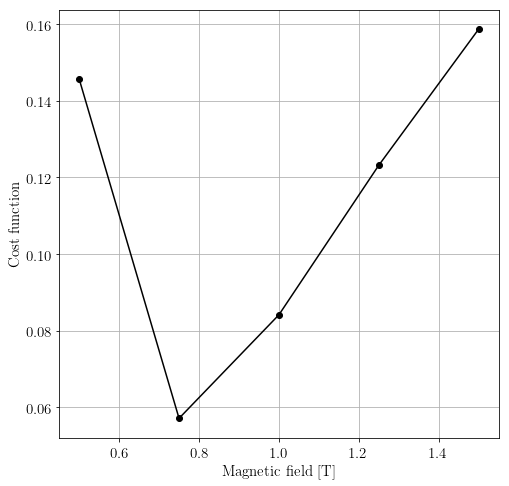

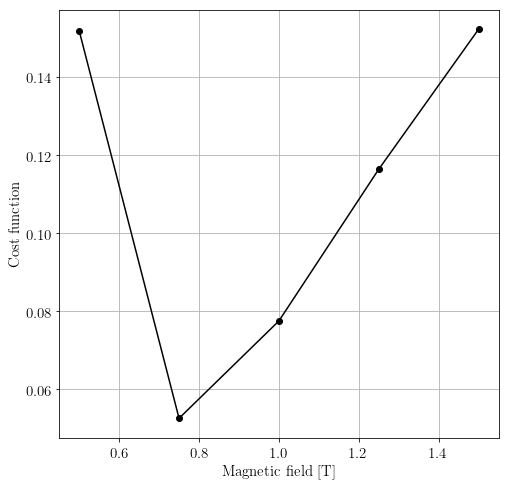

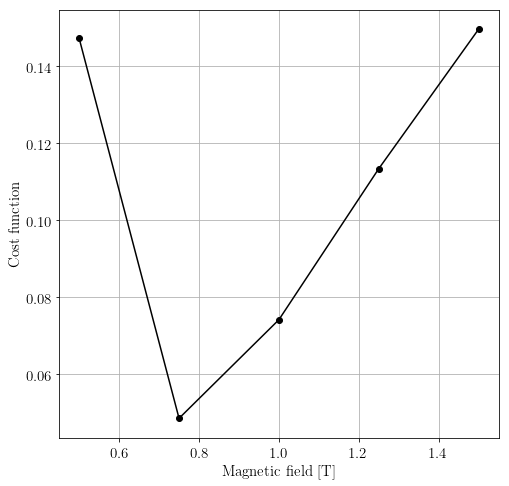

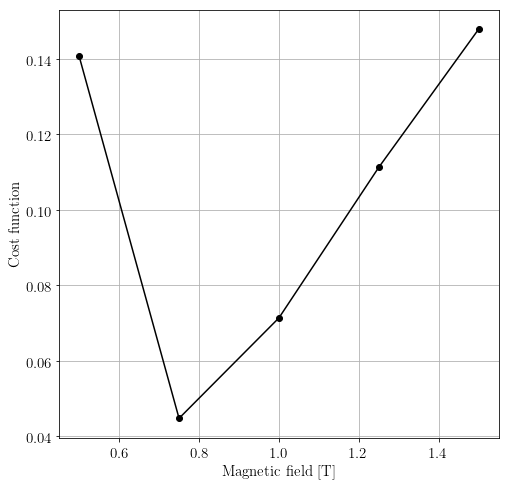

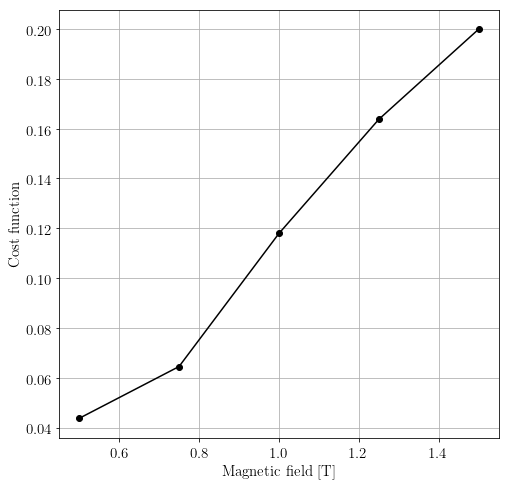

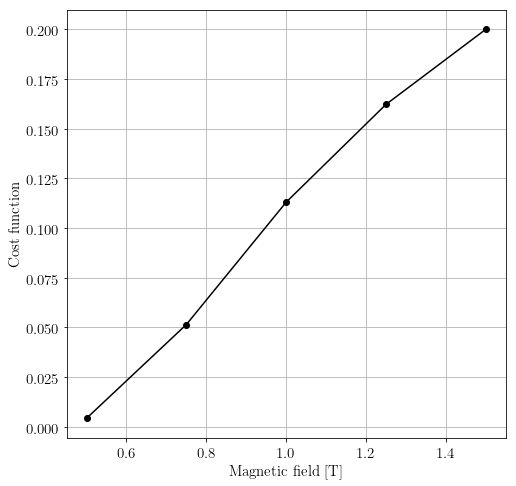

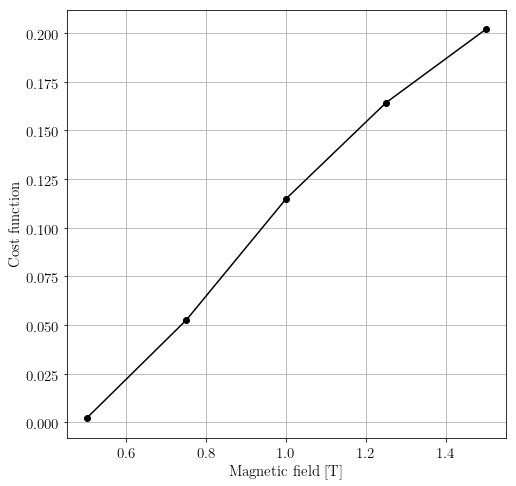

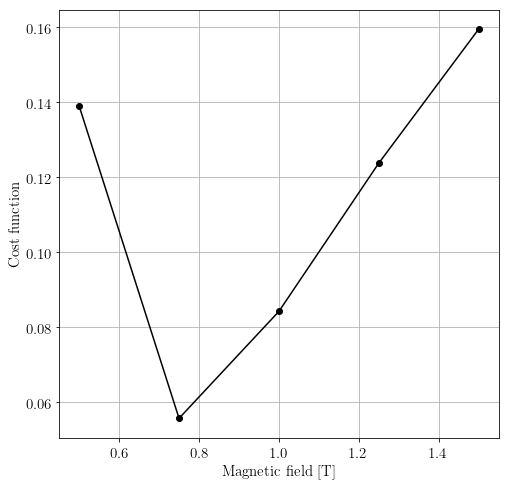

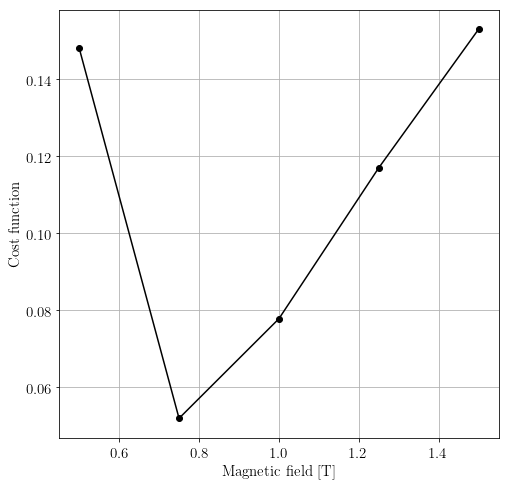

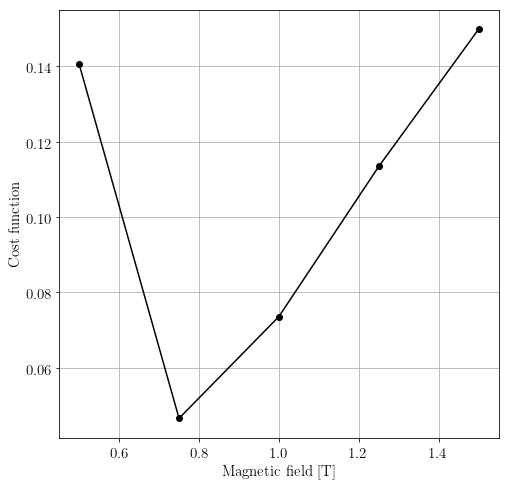

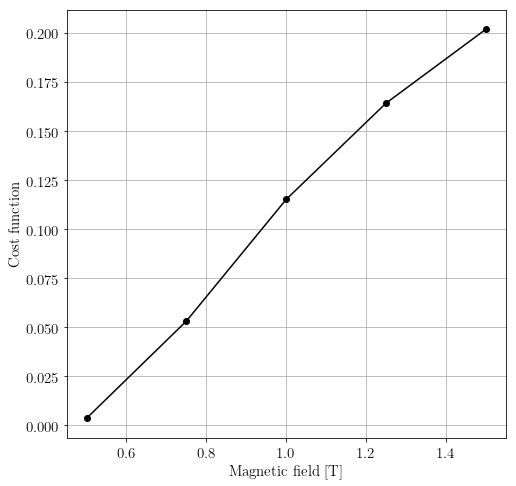

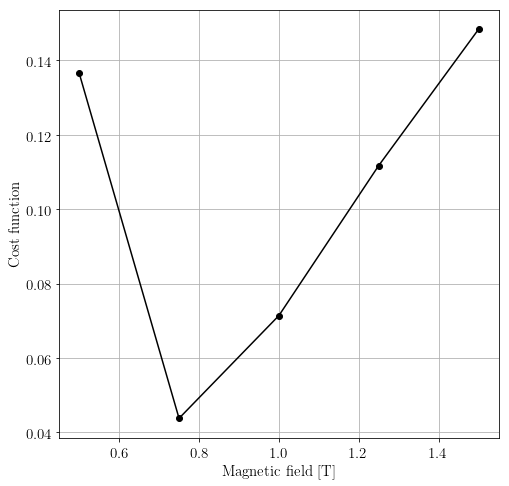

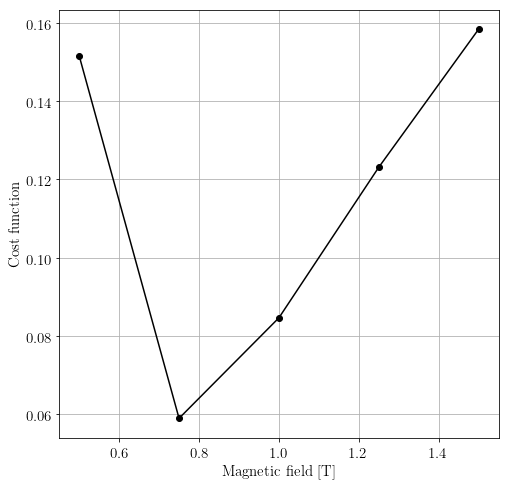

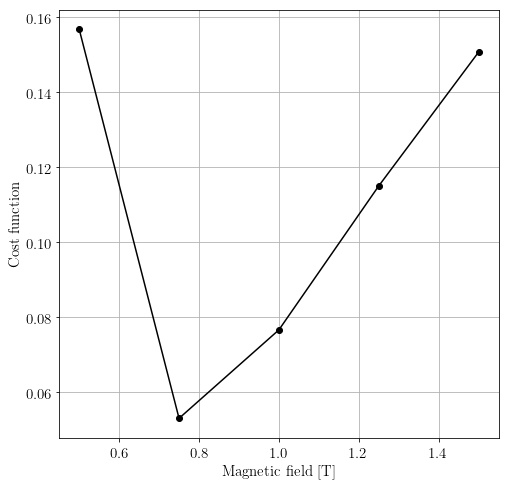

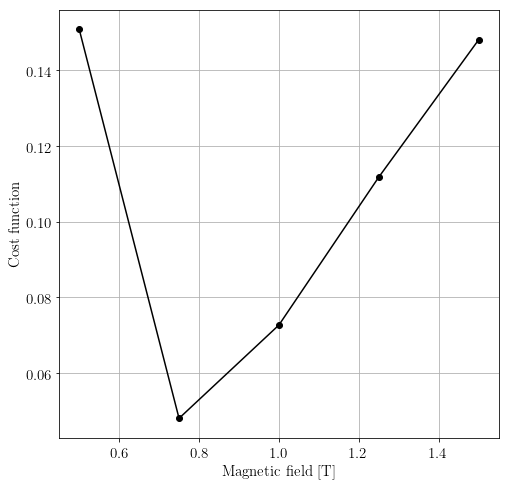

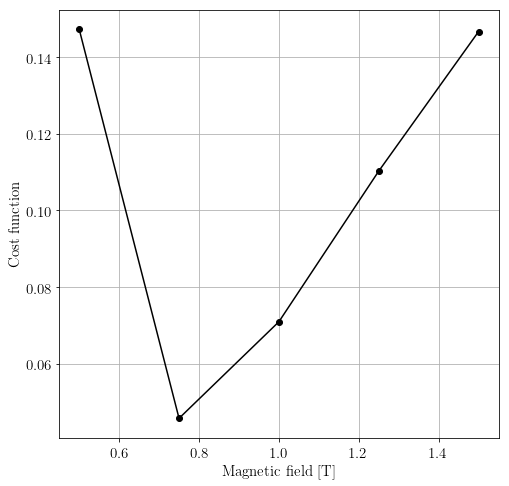

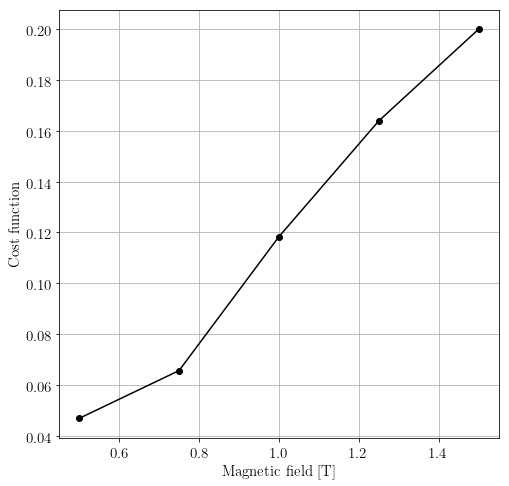

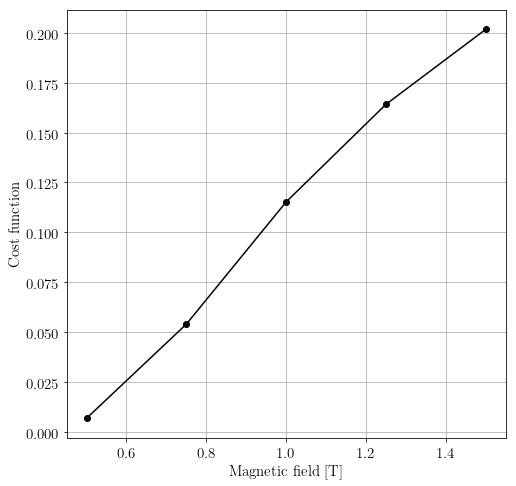

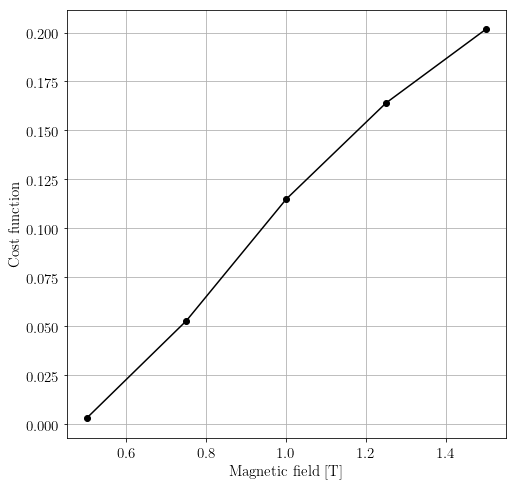

In [50]:
for results_file in results_files:
    
    fig, ax = nemplot.create_plot(xlabel="Magnetic field [T]",ylabel="Cost function")
    
    B, Kappa = np.transpose(np.loadtxt(results_file,skiprows=1))
    
    ax.plot(B, Kappa, 'ko-')
    
    ax.grid(True)